In [4]:
# %pip install -q torch

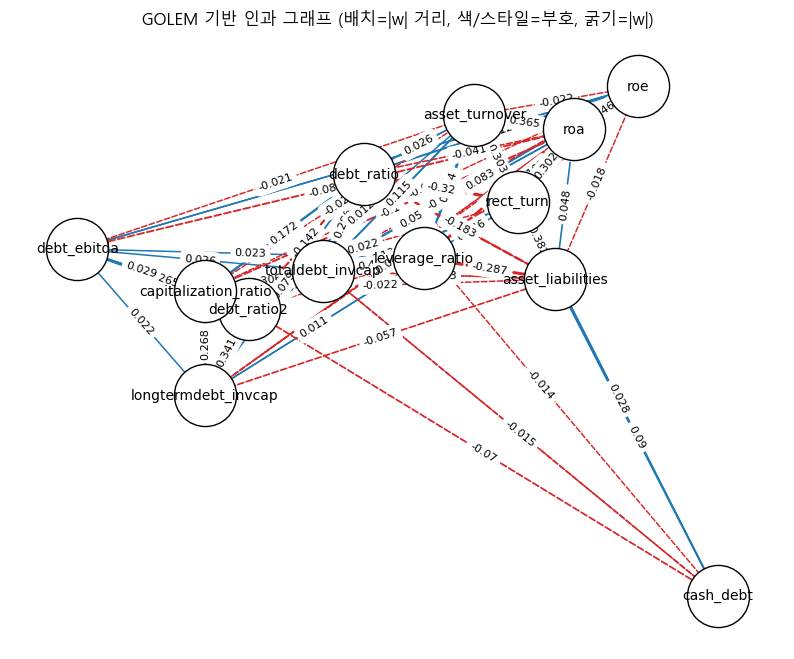

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# --- 시각화 설정 (선택) ---
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 0) 데이터 로드 (기존과 동일: df, feature_cols, X_base, y, cols_for_w, cols)
df = pd.read_csv("training_data.csv")
feature_cols = df.drop(columns=["Unnamed: 0", "label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int)
cols_for_w = list(feature_cols)
cols = cols_for_w

# 1) 표준화 데이터 (GOLEM은 연속 최적화에서 스케일 영향 ↓)
Z = StandardScaler().fit_transform(X_base.values)  # (n, d)
n, d = Z.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_t = torch.tensor(Z, dtype=torch.float32, device=device)

# 2) GOLEM(EV) 목적함수 구성
#    - 재구성오차(0.5/n ||X - XW||_F^2)
#    - L1 (sparsity), L2 (ridge)
#    - 비순환 제약: h(W)=tr(exp(W∘W)) - d  (∘: elementwise)
#    - Augmented Lagrangian: μ*h + (ρ/2)h^2
lambda1 = 2e-2   # L1 sparsity (필요시 조정)
lambda2 = 5e-2   # L2 ridge     (필요시 조정)
lr = 2e-2
inner_steps = 1500   # 내부(Adam) 반복
max_outer = 8        # 바깥(라그랑주/패널티 갱신) 반복
h_tol = 1e-8
mu = 1.0
rho = 1.0

W_param = nn.Parameter(torch.zeros(d, d, device=device))
I = torch.eye(d, device=device)
mask_offdiag = (1.0 - torch.eye(d, device=device))  # 대각선 0 유지용 마스크
optimizer = optim.Adam([W_param], lr=lr)

def acyclicity(W_eff: torch.Tensor) -> torch.Tensor:
    M = W_eff * W_eff  # elementwise square
    return torch.trace(torch.matrix_exp(M)) - d

def loss_fn(W_eff: torch.Tensor) -> torch.Tensor:
    # 재구성오차
    recon = 0.5 / n * torch.sum((X_t - X_t @ W_eff) ** 2)
    # 정규화
    l1 = lambda1 * torch.sum(torch.abs(W_eff))
    l2 = 0.5 * lambda2 * torch.sum(W_eff ** 2)
    # 비순환
    h = acyclicity(W_eff)
    aug = mu * h + 0.5 * rho * h * h
    return recon + l1 + l2 + aug, h, recon

best_loss = float('inf')
with torch.enable_grad():
    for outer in range(max_outer):
        for step in range(inner_steps):
            optimizer.zero_grad()
            W_eff = W_param * mask_offdiag  # 대각 0 강제
            loss, h_val, recon = loss_fn(W_eff)
            loss.backward()
            optimizer.step()

            # 대각 0 강제(수치오차 cleanup)
            with torch.no_grad():
                W_param.data = W_param.data * mask_offdiag

            if loss.item() < best_loss:
                best_loss = loss.item()

        # AugLag 업데이트
        with torch.no_grad():
            W_eff = W_param * mask_offdiag
            h_curr = acyclicity(W_eff).item()
        if h_curr <= h_tol:
            # 충분히 DAG에 가까우면 종료
            break
        mu = mu + rho * h_curr
        rho *= 10.0  # 점진적 패널티 강화

# 3) 결과 행렬 W 추출 (numpy)
W_golem = (W_param * mask_offdiag).detach().cpu().numpy()

# 4) 시각화 파라미터
USE_QUANTILE = False     # True면 분위수 임계 사용
W_THRESHOLD = 0.01       # |W| > 0.01
W_ABS_QUANTILE = 0.90    # USE_QUANTILE=True일 때 상위 10%

def get_threshold(W, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W_golem)

# 5) 그래프 구성 (부호 유지), 레이아웃은 |w| 기반 양의 '거리'로 안정화
G = nx.DiGraph()
edges_all = []
for i in range(d):
    for j in range(d):
        if i == j:
            continue
        w = float(W_golem[i, j])  # i <- j
        if abs(w) > thr:
            u = cols[j]  # parent
            v = cols[i]  # child
            edges_all.append((u, v, w))
            G.add_edge(u, v, weight=round(w, 3))

# 배치용 보조 그래프(H): 거리=1/(|w|+ε)
eps = 1e-6
H = nx.Graph()
for u, v, data in G.edges(data=True):
    w = data.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')  # 안정적 배치

# 부호/크기 스타일
max_abs = max((abs(d["weight"]) for _, _, d in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] >= 0]
neg_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title("GOLEM 기반 인과 그래프 (배치=|w| 거리, 색/스타일=부호, 굵기=|w|)")
plt.axis("off")
plt.show()

W = W_golem


In [6]:
# =========================================================
# [추가] GOLEM W 기반 파생피처 + LightGBM O/F/OF 10-fold CV
#   - 이 블록은 네가 준 GOLEM 코드(맨 아래에서 W_golem 저장/할당까지)
#     실행된 직후에 붙여서 실행하면 됩니다.
#   - 결과 DataFrame `report`는 MultiIndex로 생성됩니다.
# =========================================================

import numpy as np
import pandas as pd
from typing import List, Dict

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss

# LightGBM (버전 호환: 콜백 사용)
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# -------------------------------------
# 설정(필요시 조정)
TOP_K_EDGES   = 5
N_SPLITS      = 10
RANDOM_STATE  = 42
PRINT_PROGRESS = True

LGBM_PARAMS = dict(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,            # 자동
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="binary",
    class_weight="balanced", # 불균형 자동 보정
    random_state=RANDOM_STATE,
    n_jobs=-1
)
EARLY_STOPPING_ROUNDS = 50
# -------------------------------------

# --- 유틸 ---
def pick_top_k_edges(W: np.ndarray, cols: List[str], top_k: int = 15):
    """
    GOLEM W 에서 (i <- j, weight=W[i,j]) 기준 상위 |w| 간선 선택
    반환: [(i, j, w_ij), ...] with i:child, j:parent
    """
    n = W.shape[0]
    flat = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            w = W[i, j]
            if w == 0.0:
                continue
            flat.append((i, j, w))
    flat.sort(key=lambda t: (abs(t[2]), t[2]), reverse=True)
    return flat[:top_k]

def expected_calibration_error(y_true, y_prob, n_bins: int = 10):
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0; total = len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins-1 else (y_prob >= left) & (y_prob <= right)
        if not np.any(mask):
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum()/total) * abs(acc - conf)
    return float(ece)

def build_feature_df(X_base: pd.DataFrame, cols: List[str], W: np.ndarray, feature_type: str = "mul", top_k: int = 15):
    """
    feature_type ∈ {"mul","mulw"}
      - mul  : (A * B)
      - mulw : w_ij * (A * B)
    규약: w_ij = W[i,j], A=cols[j](parent), B=cols[i](child)
    """
    edges = pick_top_k_edges(W, cols, top_k=top_k)
    feats = {}
    for i, j, w_ij in edges:
        A_name, B_name = cols[j], cols[i]
        if feature_type == "mul":
            feats[f"{A_name}_mul_{B_name}"] = X_base[A_name] * X_base[B_name]
        elif feature_type == "mulw":
            feats[f"{A_name}_mulw_{B_name}"] = w_ij * (X_base[A_name] * X_base[B_name])
        else:
            raise ValueError("feature_type must be 'mul' or 'mulw'")
    return pd.DataFrame(feats, index=X_base.index)

def run_cv_lgbm(X: pd.DataFrame, y: pd.Series, n_splits=10, random_state=42, tag: str = "") -> Dict[str, float]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []

    X_np = X.values.astype(np.float32)
    y_np = y.values.astype(int)

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np, y_np), start=1):
        if PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...", flush=True)

        X_tr, X_te = X_np[tr_idx], X_np[te_idx]
        y_tr, y_te = y_np[tr_idx], y_np[te_idx]

        # 내부 검증(조기 종료)
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )

        clf = LGBMClassifier(**LGBM_PARAMS)
        clf.fit(
            X_tr_sub, y_tr_sub,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            callbacks=[
                early_stopping(EARLY_STOPPING_ROUNDS),  # 버전 호환 조기 종료
                log_evaluation(-1)                      # 로그 숨김(보고 싶으면 10 등으로)
            ]
        )

        y_proba = clf.predict_proba(X_te)[:, 1]
        y_pred  = (y_proba >= 0.5).astype(int)

        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        try:
            aurocs.append(roc_auc_score(y_te, y_proba))
        except Exception:
            aurocs.append(np.nan)
        try:
            auprcs.append(average_precision_score(y_te, y_proba))
        except Exception:
            auprcs.append(np.nan)
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))

    return {
        "f1": float(np.nanmean(f1s)),
        "AUPRC": float(np.nanmean(auprcs)),
        "AUROC": float(np.nanmean(aurocs)),
        "Brier": float(np.nanmean(briers)),
        "ECE": float(np.nanmean(eces)),
    }

# -------------------------------------
# 1) 파생 피처 생성 (GOLEM의 W/cols/X_base를 그대로 사용)
Xf_m   = build_feature_df(X_base, cols, W, feature_type="mul",  top_k=TOP_K_EDGES)
Xf_mw  = build_feature_df(X_base, cols, W, feature_type="mulw", top_k=TOP_K_EDGES)

# 2) 평가 (O는 1회만 학습 → 재사용)
res_O      = run_cv_lgbm(X_base, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="O(original)")
res_F_m    = run_cv_lgbm(Xf_m,    y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="F(m)")
res_OF_m   = run_cv_lgbm(pd.concat([X_base, Xf_m],   axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="OF(m)")

res_F_mw   = run_cv_lgbm(Xf_mw,   y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="F(mw)")
res_OF_mw  = run_cv_lgbm(pd.concat([X_base, Xf_mw],  axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="OF(mw)")

# 3) 결과 표 구성 (저장 스니펫과 호환: MultiIndex 컬럼, 변수명 report)
col_top = ["O", "F", "OF"]
col_metrics = ["f1", "AUPRC", "AUROC", "Brier", "ECE"]
multi_cols = pd.MultiIndex.from_product([col_top, col_metrics])
index_rows = ["original", "m", "mw"]

report = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)

# original 행: O만
for met in col_metrics:
    report.loc["original", ("O", met)] = res_O[met]

# m / mw / m+mw 행 채우기
def put(row, res_F, res_OF):
    for met in col_metrics:
        report.loc[row, ("O", met)]  = res_O[met]
        report.loc[row, ("F", met)]  = res_F[met]
        report.loc[row, ("OF", met)] = res_OF[met]

put("m",    res_F_m,   res_OF_m)
put("mw",   res_F_mw,  res_OF_mw)

report = report.astype(float).round(4)
report

[O(original)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3030
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.928258	valid_0's binary_logloss: 0.286746
[O(original)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of d

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[106]	valid_0's auc: 0.920933	valid_0's binary_logloss: 0.0914904
[O(original)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[82]	valid_0's auc: 0.953858	valid_0's binary_logloss: 0.105681
[O(original)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.928164	valid_0's binary_logloss: 0.121308
[O(original)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[130]	valid_0's auc: 0.939224	valid_0's binary_logloss: 0.0781649
[O(original)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[12]	valid_0's auc: 0.934356	valid_0's binary_logloss: 0.404145
[O(original)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[92]	valid_0's auc: 0.948507	valid_0's binary_logloss: 0.0898579
[O(original)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3029
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[39]	valid_0's auc: 0.925967	valid_0's binary_logloss: 0.198154
[O(original)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[148]	valid_0's auc: 0.924012	valid_0's binary_logloss: 0.080701
[O(original)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.927801	valid_0's binary_logloss: 0.132482
[F(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[54]	valid_0's auc: 0.88942	valid_0's binary_logloss: 0.214378
[F(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[103]	valid_0's auc: 0.868488	valid_0's binary_logloss: 0.152243
[F(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.920936	valid_0's binary_logloss: 0.192864
[F(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[52]	valid_0's auc: 0.883223	valid_0's binary_logloss: 0.21892
[F(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[168]	valid_0's auc: 0.888639	valid_0's binary_logloss: 0.129516
[F(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[140]	valid_0's auc: 0.894098	valid_0's binary_logloss: 0.126766
[F(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.913108	valid_0's binary_logloss: 0.172968
[F(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[38]	valid_0's auc: 0.908645	valid_0's binary_logloss: 0.274787
[F(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[68]	valid_0's auc: 0.877973	valid_0's binary_logloss: 0.192971
[F(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[26]	valid_0's auc: 0.891006	valid_0's binary_logloss: 0.323788
[OF(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4305
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[35]	valid_0's auc: 0.931799	valid_0's binary_logloss: 0.199338
[OF(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4301
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[175]	valid_0's auc: 0.909744	valid_0's binary_logloss: 0.079661
[OF(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4300
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[34]	valid_0's auc: 0.952695	valid_0's binary_logloss: 0.215264
[OF(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[52]	valid_0's auc: 0.920025	valid_0's binary_logloss: 0.153392
[OF(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4307
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[37]	valid_0's auc: 0.940676	valid_0's binary_logloss: 0.189794
[OF(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4301
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[25]	valid_0's auc: 0.933506	valid_0's binary_logloss: 0.260345
[OF(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[47]	valid_0's auc: 0.950917	valid_0's binary_logloss: 0.151831
[OF(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4304
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[14]	valid_0's auc: 0.921097	valid_0's binary_logloss: 0.376908
[OF(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4300
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.920768	valid_0's binary_logloss: 0.0894401
[OF(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[2]	valid_0's auc: 0.901384	valid_0's binary_logloss: 0.623972
[F(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[54]	valid_0's auc: 0.88942	valid_0's binary_logloss: 0.214378
[F(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[103]	valid_0's auc: 0.868488	valid_0's binary_logloss: 0.152243
[F(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.92094	valid_0's binary_logloss: 0.192859
[F(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[82]	valid_0's auc: 0.885382	valid_0's binary_logloss: 0.170614
[F(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[168]	valid_0's auc: 0.88863	valid_0's binary_logloss: 0.129572
[F(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[140]	valid_0's auc: 0.894098	valid_0's binary_logloss: 0.126766
[F(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.913108	valid_0's binary_logloss: 0.172968
[F(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[38]	valid_0's auc: 0.908645	valid_0's binary_logloss: 0.274787
[F(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[68]	valid_0's auc: 0.877973	valid_0's binary_logloss: 0.192968
[F(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[26]	valid_0's auc: 0.891011	valid_0's binary_logloss: 0.32378
[OF(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4305
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[35]	valid_0's auc: 0.931799	valid_0's binary_logloss: 0.199338
[OF(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4301
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[175]	valid_0's auc: 0.909744	valid_0's binary_logloss: 0.079661
[OF(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4300
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[34]	valid_0's auc: 0.952695	valid_0's binary_logloss: 0.215264
[OF(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[63]	valid_0's auc: 0.928092	valid_0's binary_logloss: 0.130102
[OF(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4307
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[37]	valid_0's auc: 0.940676	valid_0's binary_logloss: 0.189794
[OF(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4301
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[25]	valid_0's auc: 0.933506	valid_0's binary_logloss: 0.260345
[OF(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[47]	valid_0's auc: 0.950917	valid_0's binary_logloss: 0.151831
[OF(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4304
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[14]	valid_0's auc: 0.921097	valid_0's binary_logloss: 0.376908
[OF(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4300
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.920772	valid_0's binary_logloss: 0.0894473
[OF(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[2]	valid_0's auc: 0.901384	valid_0's binary_logloss: 0.623972


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


O                                      F                  \
              f1   AUPRC   AUROC  Brier     ECE      f1   AUPRC   AUROC   
original  0.3923  0.4337  0.9152  0.042  0.0952     NaN     NaN     NaN   
m         0.3923  0.4337  0.9152  0.042  0.0952  0.2458  0.2276  0.8571   
mw        0.3923  0.4337  0.9152  0.042  0.0952  0.2478  0.2264  0.8578   

                              OF                                  
           Brier     ECE      f1   AUPRC   AUROC   Brier     ECE  
original     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
m         0.0571  0.1148  0.3558  0.4294  0.8988  0.0643  0.1559  
mw        0.0558  0.1099  0.3593  0.4285  0.8997  0.0639  0.1539

In [7]:
# report: MultiIndex 컬럼의 결과 DataFrame이 이미 존재한다고 가정
# format 옵션: "multi" | "flat" | "long"
save_format = "multi"  # 원하는 포맷으로 변경

if save_format == "multi":
    out_path = "report_golem_lightgbm_5.csv"
    report.to_csv(out_path, encoding="utf-8-sig")

elif save_format == "flat":
    out_path = "report_golem_lightgbm_5.csv"
    flat_cols = [f"{top}_{met}" for top, met in report.columns.to_list()]
    report_flat = report.copy()
    report_flat.columns = flat_cols
    report_flat.to_csv(out_path, encoding="utf-8-sig")

elif save_format == "long":
    out_path = "report_golem_lightgbm_5.csv"
    report_long = (
        report
        .rename_axis(index="row", columns=["set", "metric"])
        .stack(["set", "metric"])
        .to_frame("value")
        .reset_index()[["row", "set", "metric", "value"]]
    )
    report_long.to_csv(out_path, index=False, encoding="utf-8-sig")
else:
    raise ValueError("save_format must be one of: 'multi', 'flat', 'long'")

print(f"Saved: {out_path} (format={save_format})")


Saved: report_golem_lightgbm_5.csv (format=multi)


In [9]:
# === Confusion Matrix (GOLEM W + LightGBM, O/F/OF; m+mw 제외) ===
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import numpy as np, pandas as pd, re
from pathlib import Path

# 파일명 구성
DAG_ALGO   = "golem"
MODEL_NAME = "lightgbm_5"

def _snake(s: str) -> str:
    s = s.strip().lower()
    s = s.replace("+"," ").replace("/"," ").replace("-"," ")
    s = re.sub(r"[^a-z0-9]+","_", s)
    return re.sub(r"_+", "_", s).strip("_")

SAVE_DIR  = Path("./confusion_matrix")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
SAVE_PATH = SAVE_DIR / f"{_snake(DAG_ALGO)}_{_snake(MODEL_NAME)}_cm.csv"

THRESH = 0.5

def _oof_preds_lgbm(
    X: pd.DataFrame, y: pd.Series,
    n_splits: int, seed: int, tag: str
):
    """LightGBM 설정(상위 셀의 LGBM_PARAMS / EARLY_STOPPING_ROUNDS) 그대로 사용한 10-fold OOF 수집"""
    X_np = X.values.astype(np.float32)
    y_np = y.values.astype(int)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    y_true_all, y_proba_all = [], []
    for tr_idx, te_idx in skf.split(X_np, y_np):
        X_tr, X_te = X_np[tr_idx], X_np[te_idx]
        y_tr, y_te = y_np[tr_idx], y_np[te_idx]

        # 내부 검증(조기 종료)
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=seed, stratify=y_tr
        )

        clf = LGBMClassifier(**LGBM_PARAMS)
        clf.fit(
            X_tr_sub, y_tr_sub,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            callbacks=[early_stopping(EARLY_STOPPING_ROUNDS), log_evaluation(-1)]
        )

        y_proba = clf.predict_proba(X_te)[:, 1]
        y_true_all.append(y_te)
        y_proba_all.append(y_proba)

    y_true_all  = np.concatenate(y_true_all)
    y_proba_all = np.concatenate(y_proba_all)
    y_pred_all  = (y_proba_all >= THRESH).astype(int)
    return {"y_true": y_true_all, "y_proba": y_proba_all, "y_pred": y_pred_all, "tag": tag}

def _cm(res):
    cm = confusion_matrix(res["y_true"], res["y_pred"], labels=[0, 1])
    return {"TN": int(cm[0,0]), "FP": int(cm[0,1]), "FN": int(cm[1,0]), "TP": int(cm[1,1])}

# === O/F/OF OOF 예측 수집 (m+mw 제외) ===
res_O     = _oof_preds_lgbm(X_base,                             y, N_SPLITS, RANDOM_STATE, "O")
res_F_m   = _oof_preds_lgbm(Xf_m,                               y, N_SPLITS, RANDOM_STATE, "F(m)")
res_OF_m  = _oof_preds_lgbm(pd.concat([X_base, Xf_m],  axis=1), y, N_SPLITS, RANDOM_STATE, "OF(m)")
res_F_mw  = _oof_preds_lgbm(Xf_mw,                              y, N_SPLITS, RANDOM_STATE, "F(mw)")
res_OF_mw = _oof_preds_lgbm(pd.concat([X_base, Xf_mw], axis=1), y, N_SPLITS, RANDOM_STATE, "OF(mw)")

# === 표 구성 (m+mw 제거) ===
rows = [
    ("original","O", _cm(res_O)),
    ("m","F",       _cm(res_F_m)),   ("m","OF",       _cm(res_OF_m)),
    ("mw","F",      _cm(res_F_mw)),  ("mw","OF",      _cm(res_OF_mw)),
]
cm_table = pd.DataFrame(
    [(r, s, d["TN"], d["FP"], d["FN"], d["TP"]) for r, s, d in rows],
    columns=["row","set","TN","FP","FN","TP"]
).set_index(["row","set"])

cm_table.to_csv(SAVE_PATH, encoding="utf-8-sig")
print(f"[saved] {SAVE_PATH.resolve()}")


[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3030
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.928258	valid_0's binary_logloss: 0.286746
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used featu

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[106]	valid_0's auc: 0.920933	valid_0's binary_logloss: 0.0914904
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[82]	valid_0's auc: 0.953858	valid_0's binary_logloss: 0.105681
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.928164	valid_0's binary_logloss: 0.121308
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[130]	valid_0's auc: 0.939224	valid_0's binary_logloss: 0.0781649
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[12]	valid_0's auc: 0.934356	valid_0's binary_logloss: 0.404145
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[92]	valid_0's auc: 0.948507	valid_0's binary_logloss: 0.0898579
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3029
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[39]	valid_0's auc: 0.925967	valid_0's binary_logloss: 0.198154
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[148]	valid_0's auc: 0.924012	valid_0's binary_logloss: 0.080701
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.927801	valid_0's binary_logloss: 0.132482
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[54]	valid_0's auc: 0.88942	valid_0's binary_logloss: 0.214378
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[103]	valid_0's auc: 0.868488	valid_0's binary_logloss: 0.152243
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.920936	valid_0's binary_logloss: 0.192864
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[52]	valid_0's auc: 0.883223	valid_0's binary_logloss: 0.21892
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[168]	valid_0's auc: 0.888639	valid_0's binary_logloss: 0.129516
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[140]	valid_0's auc: 0.894098	valid_0's binary_logloss: 0.126766
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.913108	valid_0's binary_logloss: 0.172968
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[38]	valid_0's auc: 0.908645	valid_0's binary_logloss: 0.274787
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[68]	valid_0's auc: 0.877973	valid_0's binary_logloss: 0.192971
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[26]	valid_0's auc: 0.891006	valid_0's binary_logloss: 0.323788
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4305
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[35]	valid_0's auc: 0.931799	valid_0's binary_logloss: 0.199338
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4301
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[175]	valid_0's auc: 0.909744	valid_0's binary_logloss: 0.079661
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4300
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[34]	valid_0's auc: 0.952695	valid_0's binary_logloss: 0.215264
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[52]	valid_0's auc: 0.920025	valid_0's binary_logloss: 0.153392
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4307
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[37]	valid_0's auc: 0.940676	valid_0's binary_logloss: 0.189794
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4301
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[25]	valid_0's auc: 0.933506	valid_0's binary_logloss: 0.260345
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[47]	valid_0's auc: 0.950917	valid_0's binary_logloss: 0.151831
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4304
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[14]	valid_0's auc: 0.921097	valid_0's binary_logloss: 0.376908
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4300
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.920768	valid_0's binary_logloss: 0.0894401
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[2]	valid_0's auc: 0.901384	valid_0's binary_logloss: 0.623972
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[54]	valid_0's auc: 0.88942	valid_0's binary_logloss: 0.214378
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[103]	valid_0's auc: 0.868488	valid_0's binary_logloss: 0.152243
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.92094	valid_0's binary_logloss: 0.192859
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[82]	valid_0's auc: 0.885382	valid_0's binary_logloss: 0.170614
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[168]	valid_0's auc: 0.88863	valid_0's binary_logloss: 0.129572
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[140]	valid_0's auc: 0.894098	valid_0's binary_logloss: 0.126766
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.913108	valid_0's binary_logloss: 0.172968
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[38]	valid_0's auc: 0.908645	valid_0's binary_logloss: 0.274787
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[68]	valid_0's auc: 0.877973	valid_0's binary_logloss: 0.192968
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[26]	valid_0's auc: 0.891011	valid_0's binary_logloss: 0.32378
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4305
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[35]	valid_0's auc: 0.931799	valid_0's binary_logloss: 0.199338
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4301
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[175]	valid_0's auc: 0.909744	valid_0's binary_logloss: 0.079661
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4300
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[34]	valid_0's auc: 0.952695	valid_0's binary_logloss: 0.215264
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[63]	valid_0's auc: 0.928092	valid_0's binary_logloss: 0.130102
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4307
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[37]	valid_0's auc: 0.940676	valid_0's binary_logloss: 0.189794
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4301
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[25]	valid_0's auc: 0.933506	valid_0's binary_logloss: 0.260345
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[47]	valid_0's auc: 0.950917	valid_0's binary_logloss: 0.151831
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4304
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[14]	valid_0's auc: 0.921097	valid_0's binary_logloss: 0.376908
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4300
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.920772	valid_0's binary_logloss: 0.0894473
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[2]	valid_0's auc: 0.901384	valid_0's binary_logloss: 0.623972
[saved] D:\University\3-2\PADALab\bank_failure_prediction_2\practice\Bank_Failure_Prediction_2\edge_optimization\GOLEM\confusion_matrix\golem_lightgbm_5_cm.csv


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
